In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Chargement des données
def load_data(path):
    data = pd.read_csv(path)
    data = np.array(data)
    n, m = data.shape
    np.random.shuffle(data)
    split = int(0.2 * len(data))
    # Séparation données de test et d'entraînement
    data_test = data[0:split].T
    X_test = data_test[1:n]
    y_test = data_test[0]
    X_test = X_test / 255.0
    
    data_train = data[split:n].T
    X_train = data_train[1:n]
    y_train = data_train[0]
    X_train = X_train / 255.0
    
    return X_train, y_train, X_test, y_test

# Fonctions d'activation et leurs dérivées
def relu(Z):
    return np.maximum(0, Z)

def derive_relu(Z):
    return Z > 0

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # Pour éviter l'overflow
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

# Encodage one-hot des étiquettes
def one_hot_encode(Y, nb_classes=10):
    Y_encoded = np.zeros((nb_classes, Y.size))
    Y_encoded[Y.astype(int), np.arange(Y.size)] = 1
    return Y_encoded

# Initialisation des paramètres
def initialisation(input_size=784, hidden_size=100, output_size=10):
    np.random.seed(42)  # Pour reproductibilité
    
    # Initialisation de Xavier pour éviter la saturation des gradients
    W1 = np.random.randn(hidden_size, input_size) * np.sqrt(1. / input_size)
    b1 = np.zeros((hidden_size, 1))
    
    W2 = np.random.randn(hidden_size, hidden_size) * np.sqrt(1. / hidden_size)
    b2 = np.zeros((hidden_size, 1))
    
    W3 = np.random.randn(output_size, hidden_size) * np.sqrt(1. / hidden_size)
    b3 = np.zeros((output_size, 1))
    
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}

# Propagation avant
def forward_propagation(X, params):
    W1, b1 = params['W1'], params['b1']
    W2, b2 = params['W2'], params['b2']
    W3, b3 = params['W3'], params['b3']
    
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    
    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)
    
    cache = {
        'Z1': Z1, 'A1': A1,
        'Z2': Z2, 'A2': A2,
        'Z3': Z3, 'A3': A3
    }
    
    return A3, cache

# Rétropropagation
def backward_propagation(X, Y, cache, params):
    m = X.shape[1]
    Y_encoded = one_hot_encode(Y)
    
    A3 = cache['A3']
    A2 = cache['A2']
    A1 = cache['A1']
    
    W3 = params['W3']
    W2 = params['W2']
    
    # Couche de sortie
    dZ3 = A3 - Y_encoded
    dW3 = (1 / m) * np.dot(dZ3, A2.T)
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)
    
    # Deuxième couche cachée
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = dA2 * derive_relu(cache['Z2'])
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    
    # Première couche cachée
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * derive_relu(cache['Z1'])
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {
        'dW1': dW1, 'db1': db1,
        'dW2': dW2, 'db2': db2,
        'dW3': dW3, 'db3': db3
    }
    
    return gradients

# Calcul du coût (entropie croisée)
def compute_cost(A3, Y):
    m = Y.shape[0]
    Y_encoded = one_hot_encode(Y)
    cost = -np.sum(Y_encoded * np.log(A3 + 1e-8)) / m
    return cost

# Prédiction
def predict(X, params):
    A3, _ = forward_propagation(X, params)
    return np.argmax(A3, axis=0)

# Calcul de la précision
def compute_accuracy(predictions, Y):
    return np.mean(predictions == Y)

# Mini-batch generator
def mini_batch_generator(X, Y, batch_size=128):
    m = X.shape[1]
    mini_batches = []
    
    # Shuffle
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[permutation]
    
    # Partition
    num_complete_minibatches = m // batch_size
    
    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * batch_size:(k + 1) * batch_size]
        mini_batch_Y = shuffled_Y[k * batch_size:(k + 1) * batch_size]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    # Gestion du dernier mini-batch (si nécessaire)
    if m % batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * batch_size:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * batch_size:]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    return mini_batches

# Fonction pour afficher les graphiques interactifs à chaque 10 itérations
def plot_training_progress(costs, accuracies, i, iterations, method_name):
    clear_output(wait=True)
    
    plt.figure(figsize=(15, 5))
    
    # Plot du coût
    plt.subplot(1, 2, 1)
    iterations_list = range(0, i+1, 10)
    if len(iterations_list) < len(costs):
        iterations_list = list(iterations_list) + [i]
    plt.plot(iterations_list, costs)
    plt.title(f'{method_name} - Évolution du coût')
    plt.xlabel('Itérations')
    plt.ylabel('Coût')
    plt.grid(True)
    
    # Plot de la précision
    plt.subplot(1, 2, 2)
    plt.plot(iterations_list, accuracies)
    plt.title(f'{method_name} - Évolution de la précision')
    plt.xlabel('Itérations')
    plt.ylabel('Précision')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Itération {i}/{iterations}, Coût: {costs[-1]:.4f}, Précision: {accuracies[-1]:.4f}")

# 1. Descente de Gradient Simple (Mini-Batch)
def gradient_descent(X_train, Y_train, X_test, Y_test, params, alpha=0.1, iterations=500, batch_size=128, plot_every=10, epsilon=1e-18):
    costs = []
    accuracies = []
    iterations_recorded = []
    
    for i in range(iterations):
        mini_batches = mini_batch_generator(X_train, Y_train, batch_size)
        for X_mini, Y_mini in mini_batches:
            # Forward propagation
            A3, cache = forward_propagation(X_mini, params)
            
            # Backward propagation
            gradients = backward_propagation(X_mini, Y_mini, cache, params)
            
            # Mise à jour des paramètres
            for param in params:
                params[param] = params[param] - alpha * gradients['d' + param]
        
        # Critère d'arrêt basé sur la norme du gradient
        grad_norm = np.linalg.norm([np.linalg.norm(gradients['d' + param]) for param in params])
        if grad_norm < epsilon:
            print(f"Convergence atteinte en {i+1} itérations avec Gradient Descent au point {params}.")
            break
        
        # Calcul du coût et de la précision
        if i % plot_every == 0 or i == iterations - 1:
            A3, _ = forward_propagation(X_test, params)
            cost = compute_cost(A3, Y_test)
            costs.append(cost)
            
            predictions = predict(X_test, params)
            accuracy = compute_accuracy(predictions, Y_test)
            accuracies.append(accuracy)
            iterations_recorded.append(i)
            
            print(f"Gradient descent iteration {i} : cost fonction: {cost}, accuracy: {accuracy}")
    
    return params, costs, accuracies, iterations_recorded


# 2. Gradient avec Momentum
def momentum_gradient_descent(X_train, Y_train, X_test, Y_test, params, alpha=0.1, beta1=0.9, iterations=500, batch_size=128, plot_every=10, epsilon=1e-18):
    costs = []
    accuracies = []
    iterations_recorded = []
    
    velocities = {k: np.zeros_like(v) for k, v in params.items()}
    
    for i in range(iterations):
        mini_batches = mini_batch_generator(X_train, Y_train, batch_size)
        
        for X_mini, Y_mini in mini_batches:
            # Forward propagation
            A3, cache = forward_propagation(X_mini, params)
            
            # Backward propagation
            gradients = backward_propagation(X_mini, Y_mini, cache, params)
            
            # Mise à jour des vitesses et des paramètres
            for param in params:
                velocities[param] = beta1 * velocities[param] + (1 - beta1) * gradients['d' + param]
                params[param] = params[param] - alpha * velocities[param]
        
        # Critère d'arrêt basé sur la norme du gradient
        grad_norm = np.linalg.norm([np.linalg.norm(gradients['d' + param]) for param in params])
        if grad_norm < epsilon:
            print(f"Convergence atteinte en {i+1} itérations avec Momentum au point {params}.")
            break
        
        # Évaluation sur les données de test
        if i % plot_every == 0 or i == iterations - 1:
            A3, _ = forward_propagation(X_test, params)
            cost = compute_cost(A3, Y_test)
            costs.append(cost)
            
            predictions = predict(X_test, params)
            accuracy = compute_accuracy(predictions, Y_test)
            accuracies.append(accuracy)
            iterations_recorded.append(i)
            
            print(f"Momentum iteration {i} : cost fonction: {cost}, accuracy: {accuracy}")
    
    return params, costs, accuracies, iterations_recorded

#Nestrove Momentum
def nesterov_momentum_gradient_descent(X_train, Y_train, X_test, Y_test, params, alpha=0.1, beta1=0.9, iterations=500, batch_size=128, plot_every=10, epsilon=1e-18):
    costs = []
    accuracies = []
    iterations_recorded = []
    
    velocities = {k: np.zeros_like(v) for k, v in params.items()}
    
    for i in range(iterations):
        mini_batches = mini_batch_generator(X_train, Y_train, batch_size)
        
        for X_mini, Y_mini in mini_batches:
            # Anticipation des paramètres
            params_ahead = {k: v - beta1 * velocities[k] for k, v in params.items()}
            
            # Forward propagation avec les paramètres anticipés
            _, cache = forward_propagation(X_mini, params_ahead)
            
            # Backward propagation avec les paramètres anticipés
            gradients = backward_propagation(X_mini, Y_mini, cache, params_ahead)
            
            # Mise à jour des vitesses et des paramètres
            for param in params:
                velocities[param] = beta1 * velocities[param] + (1 - beta1) * gradients['d' + param]
                params[param] = params[param] - alpha * velocities[param]
        
        # Critère d'arrêt basé sur la norme du gradient
        grad_norm = np.linalg.norm([np.linalg.norm(gradients['d' + param]) for param in params])
        if grad_norm < epsilon:
            print(f"Convergence atteinte en {i+1} itérations avec Nesterov au point {params}.")
            break
        
        # Évaluation sur les données de test
        if i % plot_every == 0 or i == iterations - 1:
            A3, _ = forward_propagation(X_test, params)
            cost = compute_cost(A3, Y_test)
            costs.append(cost)
            
            predictions = predict(X_test, params)
            accuracy = compute_accuracy(predictions, Y_test)
            accuracies.append(accuracy)
            iterations_recorded.append(i)
            
            print(f"Nesterov iteration {i} : cost fonction: {cost}, accuracy: {accuracy}")
    
    return params, costs, accuracies, iterations_recorded
    
# 4. RMSProp
def rmsprop(X_train, Y_train, X_test, Y_test, params, alpha=0.1, beta2=0.999, epsilon=1e-18, iterations=500, batch_size=128, plot_every=10):
    costs = []
    accuracies = []
    iterations_recorded = []
    
    # Initialisation des accumulateurs de gradients au carré
    squared_gradients = {k: np.zeros_like(v) for k, v in params.items()}
    
    for i in range(iterations):
        mini_batches = mini_batch_generator(X_train, Y_train, batch_size)
        
        for X_mini, Y_mini in mini_batches:
            # Forward propagation
            A3, cache = forward_propagation(X_mini, params)
            
            # Backward propagation
            gradients = backward_propagation(X_mini, Y_mini, cache, params)
            
            # Mise à jour des accumulateurs et des paramètres
            for param in params:
                squared_gradients[param] = beta2 * squared_gradients[param] + (1 - beta2) * np.power(gradients['d' + param], 2)
                params[param] = params[param] - alpha * gradients['d' + param] / (np.sqrt(squared_gradients[param]) + epsilon)
        
        # Critère d'arrêt basé sur la norme du gradient
        grad_norm = np.linalg.norm([np.linalg.norm(gradients['d' + param]) for param in params])
        if grad_norm < epsilon:
            print(f"Convergence atteinte en {i+1} itérations avec RMSProp au point {params}.")
            break
            
        # Calcul du coût et de la précision
        if i % plot_every == 0 or i == iterations - 1:
            A3, _ = forward_propagation(X_test, params)
            cost = compute_cost(A3, Y_test)
            costs.append(cost)
            
            predictions = predict(X_test, params)
            accuracy = compute_accuracy(predictions, Y_test)
            accuracies.append(accuracy)
            iterations_recorded.append(i)
            
            print(f"RMSProp iteration {i} : cost fonction: {cost}, accuracy: {accuracy}")
    
    return params, costs, accuracies, iterations_recorded

# 5. Adam
def adam(X_train, Y_train, X_test, Y_test, params, alpha=0.1, beta1=0.9, beta2=0.999, epsilon=1e-18, iterations=500, batch_size=128, plot_every=10):
    costs = []
    accuracies = []
    iterations_recorded = []
    
    # Initialisation des moments et des accumulateurs de gradients au carré
    velocities = {k: np.zeros_like(v) for k, v in params.items()}
    squared_gradients = {k: np.zeros_like(v) for k, v in params.items()}
    
    for i in range(iterations):
        mini_batches = mini_batch_generator(X_train, Y_train, batch_size)
        t = i + 1  # Compteur d'itérations (commence à 1)
        
        for X_mini, Y_mini in mini_batches:
            # Forward propagation
            A3, cache = forward_propagation(X_mini, params)
            
            # Backward propagation
            gradients = backward_propagation(X_mini, Y_mini, cache, params)
            
            # Mise à jour des moments, des accumulateurs et des paramètres
            for param in params:
                velocities[param] = beta1 * velocities[param] + (1 - beta1) * gradients['d' + param]
                squared_gradients[param] = beta2 * squared_gradients[param] + (1 - beta2) * np.power(gradients['d' + param], 2)
                
                velocity_corrected = velocities[param] / (1 - np.power(beta1, t))
                squared_grad_corrected = squared_gradients[param] / (1 - np.power(beta2, t))
                
                params[param] = params[param] - alpha * velocity_corrected / (np.sqrt(squared_grad_corrected) + epsilon)
        
        # Critère d'arrêt basé sur la norme du gradient
        grad_norm = np.linalg.norm([np.linalg.norm(gradients['d' + param]) for param in params])
        if grad_norm < epsilon:
            print(f"Convergence atteinte en {i+1} itérations avec Adam au point {params}.")
            break
            
        # Calcul du coût et de la précision
        if i % plot_every == 0 or i == iterations - 1:
            A3, _ = forward_propagation(X_test, params)
            cost = compute_cost(A3, Y_test)
            costs.append(cost)
            
            predictions = predict(X_test, params)
            accuracy = compute_accuracy(predictions, Y_test)
            accuracies.append(accuracy)
            iterations_recorded.append(i)
            
            print(f"Adam iteration {i} : cost fonction: {cost}, accuracy: {accuracy}")
    
    return params, costs, accuracies, iterations_recorded

# 6. Méthode de Newton (approximation simplifiée)
def newton_method(X_train, Y_train, X_test, Y_test, params, alpha=0.1, iterations=500, batch_size=128, plot_every=10, epsilon=1e-18):
    costs = []
    accuracies = []
    iterations_recorded = []
    
    # Constante de régularisation pour l'approximation de l'inverse hessienne
    eta = 1e-4
    
    for i in range(iterations):
        mini_batches = mini_batch_generator(X_train, Y_train, batch_size)
        
        for X_mini, Y_mini in mini_batches:
            # Forward propagation
            A3, cache = forward_propagation(X_mini, params)
            
            # Backward propagation
            gradients = backward_propagation(X_mini, Y_mini, cache, params)
            
            # Calcul de la Hessienne ou une approximation
            hessian_approx = compute_hessian_approximation(gradients, params)
            
            # Approximation simplifiée de la méthode de Newton
            for param in params:
                pseudo_hessian_inv = np.linalg.inv(hessian_approx[param] + eta * np.eye(hessian_approx[param].shape[0]))
                update = pseudo_hessian_inv.dot(gradients['d' + param])
                params[param] = params[param] - alpha * (update / np.linalg.norm(update))
        
        # Critère d'arrêt basé sur la norme du gradient
        grad_norm = np.linalg.norm([np.linalg.norm(gradients['d' + param]) for param in params])
        if grad_norm < epsilon:
            print(f"Convergence atteinte en {i+1} itérations avec Newton au point {params}.")
            break
            
        # Calcul du coût et de la précision
        if i % plot_every == 0 or i == iterations - 1:
            A3, _ = forward_propagation(X_test, params)
            cost = compute_cost(A3, Y_test)
            costs.append(cost)
            
            predictions = predict(X_test, params)
            accuracy = compute_accuracy(predictions, Y_test)
            accuracies.append(accuracy)
            iterations_recorded.append(i)
            
            print(f"Newton iteration {i} : cost fonction: {cost}, accuracy: {accuracy}")
    
    return params, costs, accuracies, iterations_recorded

def compute_hessian_approximation(gradients, params):
    # Cette fonction devrait calculer une approximation de la Hessienne
    # Pour simplifier, on retourne une matrice identité avec une petite valeur ajoutée pour la régularisation
    hessian_approx = {}
    for param in params:
        hessian_approx[param] = np.eye(params[param].shape[0]) * 1e-3
    return hessian_approx

# Fonction pour tester le modèle
def test_model(X_test, Y_test, params):
    predictions = predict(X_test, params)
    accuracy = compute_accuracy(predictions, Y_test)
    print(f"Précision sur l'ensemble de test: {accuracy:.4f}")
    return accuracy

# Fonction pour visualiser un chiffre et sa prédiction
def visualize_prediction(X_test, Y_test, params, index):
    prediction = predict(X_test[:, index:index+1], params)[0]
    label = Y_test[index]
    
    print(f"Prédiction: {prediction}")
    print(f"Étiquette réelle: {label}")
    
    # Affichage de l'image
    image = X_test[:, index].reshape(28, 28) * 255
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')
    plt.title(f"Prédiction: {prediction}, Réelle: {label}")
    plt.axis('off')
    plt.show()

# Fonction pour comparer les résultats de toutes les méthodes à la fin
def plot_final_comparison(results):
    plt.figure(figsize=(15, 10))
    
    # Plot des coûts
    plt.subplot(2, 1, 1)
    for name, result in results.items():
        plt.plot(result['iterations'], result['costs'], label=name)
    
    plt.title('Comparaison de l\'évolution du coût')
    plt.xlabel('Itérations')
    plt.ylabel('Coût')
    plt.legend()
    plt.grid(True)
    
    # Plot des précisions
    plt.subplot(2, 1, 2)
    for name, result in results.items():
        plt.plot(result['iterations'], result['accuracies'], label=name)
    
    plt.title('Comparaison de l\'évolution de la précision')
    plt.xlabel('Itérations')
    plt.ylabel('Précision')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Comparaison des précisions de test
    test_accuracies = {name: result['test_accuracy'] for name, result in results.items()}
    
    plt.figure(figsize=(12, 6))
    plt.bar(test_accuracies.keys(), test_accuracies.values())
    plt.title('Comparaison des précisions sur l\'ensemble de test')
    plt.xlabel('Méthode')
    plt.ylabel('Précision')
    plt.ylim(0.8, 1.0)  # Ajustez selon vos résultats
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [6]:
# Cellules d'exécution pour un notebook Jupyter
# Cellule 1: Charger les données
# Remplacez par le chemin de votre fichier MNIST
mnist_path = "/kaggle/input/numbers/mnist.csv"
print("Chargement des données...")
X_train, Y_train, X_test, Y_test = load_data(mnist_path)
print(f"Données chargées: {X_train.shape[1]} exemples d'entraînement, {X_test.shape[1]} exemples de test")



Chargement des données...
Données chargées: 33600 exemples d'entraînement, 8400 exemples de test


In [7]:
# Cellule 2: Exécuter la descente de gradient simple
print("Entraînement avec Descente de Gradient Simple...")
params_gd = initialisation()
params_gd, costs_gd, accuracies_gd, iterations_gd = gradient_descent(
    X_train, Y_train, X_test, Y_test, params_gd, alpha=0.1, iterations=500, batch_size=128, plot_every=10
)
test_accuracy_gd = test_model(X_test, Y_test, params_gd)



Entraînement avec Descente de Gradient Simple...
Gradient descent iteration 0 : cost fonction: 0.34606694551794703, accuracy: 0.8977380952380952
Gradient descent iteration 10 : cost fonction: 0.13140840905481496, accuracy: 0.9620238095238095
Gradient descent iteration 20 : cost fonction: 0.10713249421076886, accuracy: 0.971547619047619
Gradient descent iteration 30 : cost fonction: 0.11233368405782382, accuracy: 0.9704761904761905
Gradient descent iteration 40 : cost fonction: 0.11803934056402912, accuracy: 0.9722619047619048
Gradient descent iteration 50 : cost fonction: 0.1255895177183603, accuracy: 0.9723809523809523
Gradient descent iteration 60 : cost fonction: 0.12858975894096925, accuracy: 0.9716666666666667
Gradient descent iteration 70 : cost fonction: 0.13118601875147468, accuracy: 0.9720238095238095
Gradient descent iteration 80 : cost fonction: 0.1355799643375033, accuracy: 0.9719047619047619
Gradient descent iteration 90 : cost fonction: 0.13657237646663112, accuracy: 0.97

In [8]:
# Cellule 3: Exécuter l'optimisation avec Momentum
print("Entraînement avec Momentum...")
params_momentum = initialisation()
params_momentum, costs_momentum, accuracies_momentum, iterations_momentum = momentum_gradient_descent(
    X_train, Y_train,X_test, Y_test, params_momentum, alpha=0.1, beta1=0.9, iterations=500, batch_size=128, plot_every=10
)
test_accuracy_momentum = test_model(X_test, Y_test, params_momentum)



Entraînement avec Momentum...
Momentum iteration 0 : cost fonction: 0.3466457780303578, accuracy: 0.8996428571428572
Momentum iteration 10 : cost fonction: 0.12575778956756348, accuracy: 0.9645238095238096
Momentum iteration 20 : cost fonction: 0.10910400340239487, accuracy: 0.9703571428571428
Momentum iteration 30 : cost fonction: 0.11738853934035479, accuracy: 0.969047619047619
Momentum iteration 40 : cost fonction: 0.12317173437839311, accuracy: 0.9710714285714286
Momentum iteration 50 : cost fonction: 0.13046238920779255, accuracy: 0.9714285714285714
Momentum iteration 60 : cost fonction: 0.13497222456455812, accuracy: 0.9709523809523809
Momentum iteration 70 : cost fonction: 0.1378399175104029, accuracy: 0.971547619047619
Momentum iteration 80 : cost fonction: 0.14192578053483365, accuracy: 0.9713095238095238
Momentum iteration 90 : cost fonction: 0.1440440173959671, accuracy: 0.9713095238095238
Momentum iteration 100 : cost fonction: 0.14653193967309247, accuracy: 0.9717857142857

In [9]:
# Cellule 4: Exécuter l'optimisation avec Nesterov Momentum
print("Entraînement avec Nesterov Momentum...")
params_nesterov = initialisation()
params_nesterov, costs_nesterov, accuracies_nesterov, iterations_nesterov = nesterov_momentum_gradient_descent(
    X_train, Y_train, X_test, Y_test, params_nesterov, alpha=0.1, beta1=0.9, iterations=500, batch_size=128, plot_every=10
)
test_accuracy_nesterov = test_model(X_test, Y_test, params_nesterov)



Entraînement avec Nesterov Momentum...
Nesterov iteration 0 : cost fonction: 0.3259720222452343, accuracy: 0.9072619047619047
Nesterov iteration 10 : cost fonction: 0.12027842509006034, accuracy: 0.9667857142857142
Nesterov iteration 20 : cost fonction: 0.106311842494954, accuracy: 0.9714285714285714
Nesterov iteration 30 : cost fonction: 0.11098747548490204, accuracy: 0.9705952380952381
Nesterov iteration 40 : cost fonction: 0.11686718194292192, accuracy: 0.9720238095238095
Nesterov iteration 50 : cost fonction: 0.123725798266807, accuracy: 0.9722619047619048
Nesterov iteration 60 : cost fonction: 0.12811662662582513, accuracy: 0.9722619047619048
Nesterov iteration 70 : cost fonction: 0.1313397493736242, accuracy: 0.9720238095238095
Nesterov iteration 80 : cost fonction: 0.13512068968489996, accuracy: 0.9721428571428572
Nesterov iteration 90 : cost fonction: 0.1369502507599238, accuracy: 0.9726190476190476
Nesterov iteration 100 : cost fonction: 0.1393309787768026, accuracy: 0.9726190

In [10]:
# Cellule 5: Exécuter l'optimisation avec RMSProp
print("Entraînement avec RMSProp...")
params_rmsprop = initialisation()
params_rmsprop, costs_rmsprop, accuracies_rmsprop, iterations_rmsprop = rmsprop(
    X_train, Y_train, X_test, Y_test, params_rmsprop, alpha=0.01, beta2=0.999, iterations=500, batch_size=128, plot_every=10
)
test_accuracy_rmsprop = test_model(X_test, Y_test, params_rmsprop)



Entraînement avec RMSProp...
RMSProp iteration 0 : cost fonction: 0.688249292370755, accuracy: 0.7713095238095238
RMSProp iteration 10 : cost fonction: 0.2878945913794289, accuracy: 0.9213095238095238
RMSProp iteration 20 : cost fonction: 0.2951117407683805, accuracy: 0.9277380952380953
RMSProp iteration 30 : cost fonction: 0.3049742027448206, accuracy: 0.9308333333333333
RMSProp iteration 40 : cost fonction: 0.30944337425267426, accuracy: 0.9338095238095238
RMSProp iteration 50 : cost fonction: 0.3352813211756696, accuracy: 0.9384523809523809
RMSProp iteration 60 : cost fonction: 0.3362041217663485, accuracy: 0.9385714285714286
RMSProp iteration 70 : cost fonction: 0.3703860722021774, accuracy: 0.9357142857142857
RMSProp iteration 80 : cost fonction: 0.3938308382280919, accuracy: 0.9357142857142857
RMSProp iteration 90 : cost fonction: 0.44149689430128486, accuracy: 0.9298809523809524
RMSProp iteration 100 : cost fonction: 0.394468917114123, accuracy: 0.940595238095238
RMSProp iterati

In [11]:
# Cellule 6: Exécuter l'optimisation avec Adam
print("Entraînement avec Adam...")
params_adam = initialisation()
params_adam, costs_adam, accuracies_adam, iterations_adam = adam(
    X_train, Y_train, X_test, Y_test, params_adam, alpha=0.01, beta1=0.9, beta2=0.999, iterations=500, batch_size=128, plot_every=10
)
test_accuracy_adam = test_model(X_test, Y_test, params_adam)



Entraînement avec Adam...
Adam iteration 0 : cost fonction: 0.1518432363720172, accuracy: 0.9561904761904761
Adam iteration 10 : cost fonction: 0.13723449533138804, accuracy: 0.9719047619047619
Adam iteration 20 : cost fonction: 0.17099102376358283, accuracy: 0.973452380952381
Adam iteration 30 : cost fonction: 0.17993147595007852, accuracy: 0.9744047619047619
Adam iteration 40 : cost fonction: 0.19515792665055232, accuracy: 0.9748809523809524
Adam iteration 50 : cost fonction: 0.21193978237287267, accuracy: 0.9752380952380952
Adam iteration 60 : cost fonction: 0.22751503481382004, accuracy: 0.975
Adam iteration 70 : cost fonction: 0.2428990426618256, accuracy: 0.9747619047619047
Adam iteration 80 : cost fonction: 0.2562394770431483, accuracy: 0.9748809523809524
Adam iteration 90 : cost fonction: 0.2665949839164445, accuracy: 0.9752380952380952
Adam iteration 100 : cost fonction: 0.27678409720904296, accuracy: 0.9747619047619047
Adam iteration 110 : cost fonction: 0.2878003311580275, a

In [16]:
# Cellule 7: Exécuter l'optimisation avec la méthode de Newton approximée
print("Entraînement avec la méthode de Newton approximée...")
params_newton = initialisation()
params_newton, costs_newton, accuracies_newton, iterations_newton = newton_method(
    X_train, Y_train, X_test, Y_test, params_newton, alpha=0.1, iterations=500, batch_size=128, plot_every=10
)
test_accuracy_newton = test_model(X_test, Y_test, params_newton)

Entraînement avec la méthode de Newton approximée...
Newton iteration 0 : cost fonction: 0.30772271809165874, accuracy: 0.9108333333333334
Newton iteration 10 : cost fonction: 0.114821004350013, accuracy: 0.9704761904761905
Newton iteration 20 : cost fonction: 0.1555638110375268, accuracy: 0.9721428571428572
Newton iteration 30 : cost fonction: 0.2104175856616731, accuracy: 0.9738095238095238
Newton iteration 40 : cost fonction: 0.2836587378662155, accuracy: 0.9741666666666666
Newton iteration 50 : cost fonction: 0.33210085688493407, accuracy: 0.9745238095238096
Newton iteration 60 : cost fonction: 0.3581017167733906, accuracy: 0.9751190476190477
Convergence atteinte en 62 itérations avec Newton au point {'W1': array([[ 0.01773979, -0.00493801,  0.02313173, ..., -0.04769087,
         0.01357849,  0.02180663],
       [ 0.01999252,  0.03859931,  0.02978293, ..., -0.01004741,
         0.00239253,  0.0184264 ],
       [-0.05580521, -0.01889474,  0.0283666 , ..., -0.01400045,
         0.037

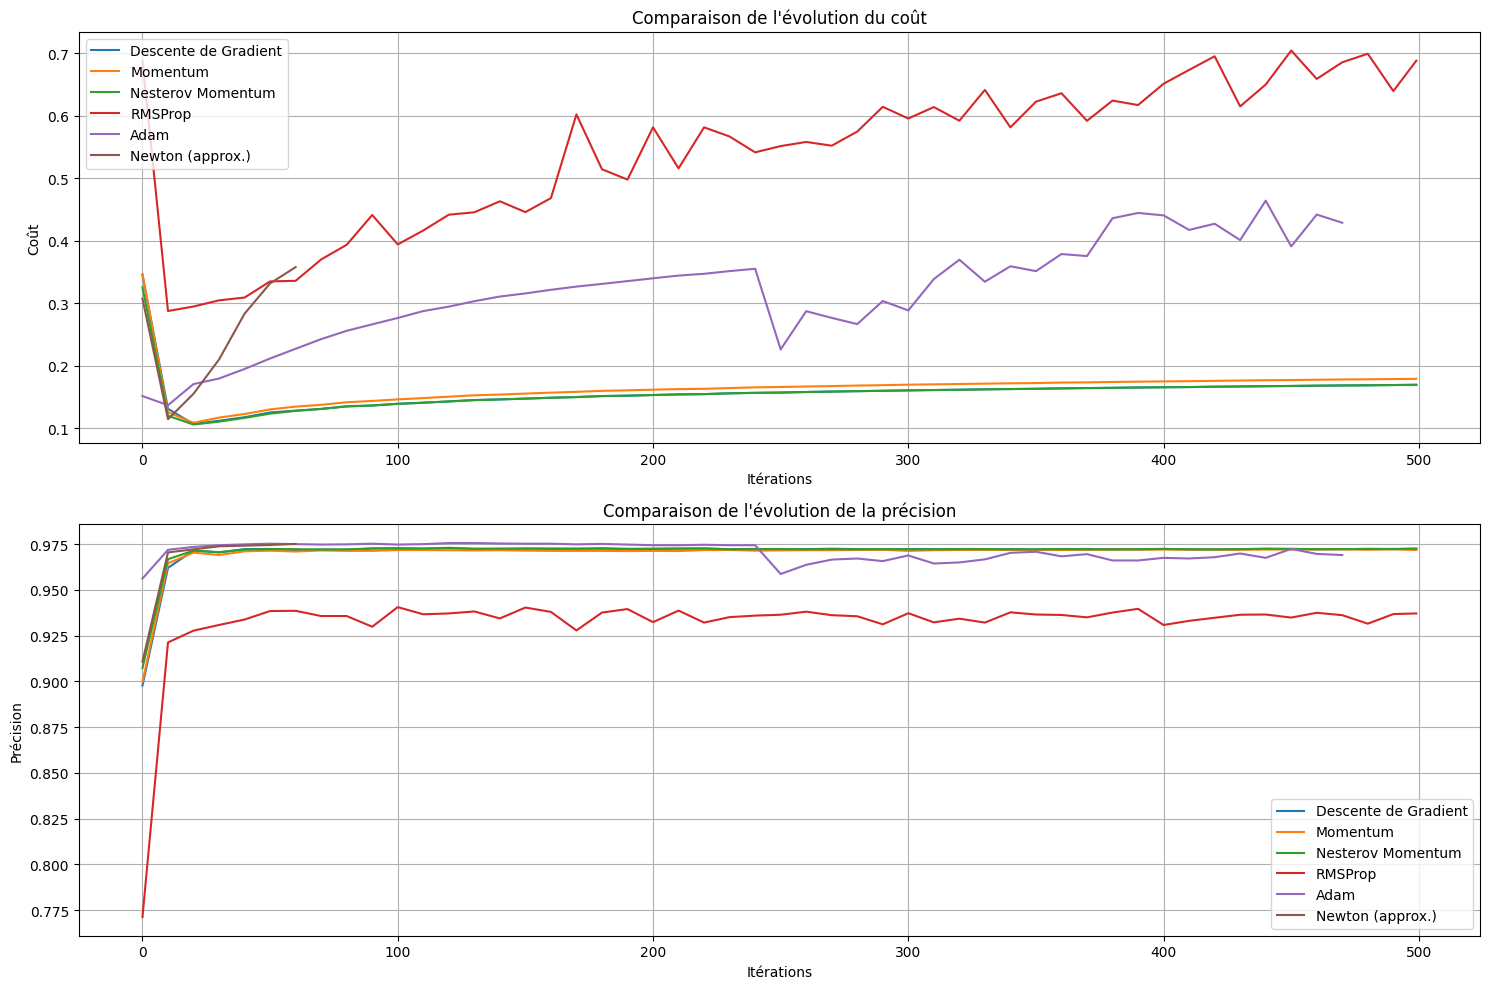

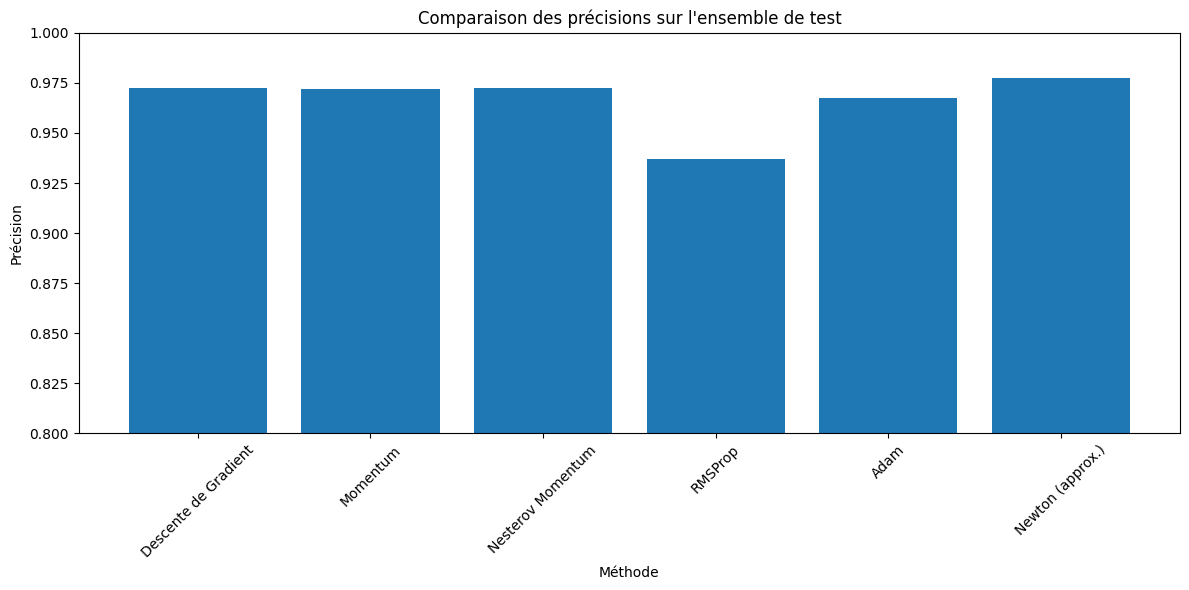

In [17]:


# Cellule 8: Comparer toutes les méthodes
results = {
    "Descente de Gradient": {
        "params": params_gd,
        "costs": costs_gd,
        "accuracies": accuracies_gd,
        "iterations": iterations_gd,
        "test_accuracy": test_accuracy_gd
    },
    "Momentum": {
        "params": params_momentum,
        "costs": costs_momentum,
        "accuracies": accuracies_momentum,
        "iterations": iterations_momentum,
        "test_accuracy": test_accuracy_momentum
    },
    "Nesterov Momentum": {
        "params": params_nesterov,
        "costs": costs_nesterov,
        "accuracies": accuracies_nesterov,
        "iterations": iterations_nesterov,
        "test_accuracy": test_accuracy_nesterov
    },
    "RMSProp": {
        "params": params_rmsprop,
        "costs": costs_rmsprop,
        "accuracies": accuracies_rmsprop,
        "iterations": iterations_rmsprop,
        "test_accuracy": test_accuracy_rmsprop
    },
    "Adam": {
        "params": params_adam,
        "costs": costs_adam,
        "accuracies": accuracies_adam,
        "iterations": iterations_adam,
        "test_accuracy": test_accuracy_adam
    },
    "Newton (approx.)": {
        "params": params_newton,
        "costs": costs_newton,
        "accuracies": accuracies_newton,
        "iterations": iterations_newton,
        "test_accuracy": test_accuracy_newton
    }
}

plot_final_comparison(results)




Meilleure méthode: Descente de Gradient
Prédiction: 0
Étiquette réelle: 0


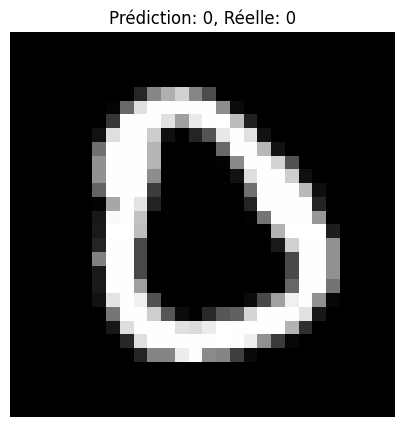

Prédiction: 5
Étiquette réelle: 5


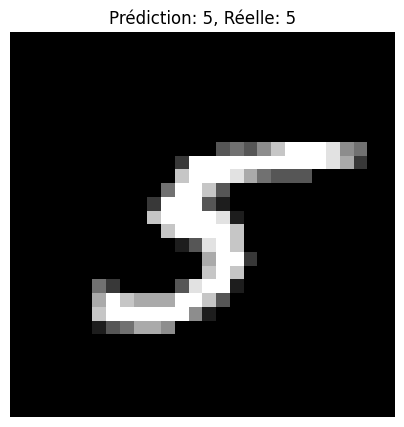

Prédiction: 2
Étiquette réelle: 2


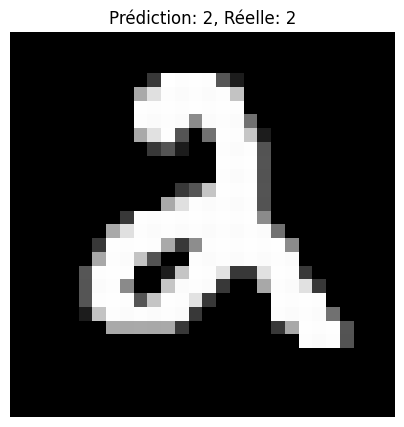

Prédiction: 6
Étiquette réelle: 5


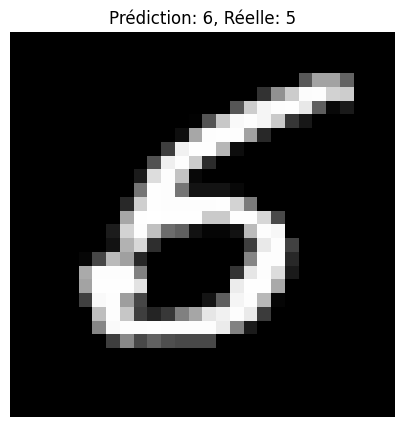

Prédiction: 1
Étiquette réelle: 1


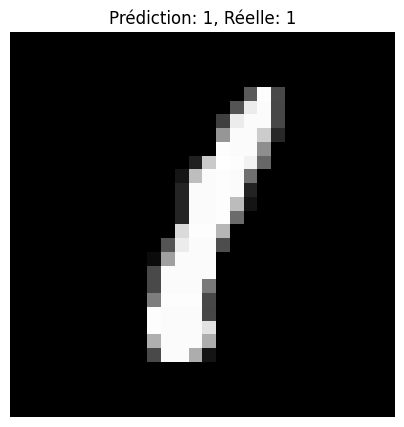

In [14]:
# Cellule 9: Visualiser quelques prédictions avec la meilleure méthode
best_method = max(results.items(), key=lambda x: x[1]['test_accuracy'])[0]
print(f"\nMeilleure méthode: {best_method}")

for i in range(5):
    idx = np.random.randint(0, X_test.shape[1])
    visualize_prediction(X_test, Y_test, results[best_method]['params'], idx)

Training with rmsprop...
Cost after iteration 0: 0.08960510316835066
Cost after iteration 10: 0.03259473422618493
Cost after iteration 20: 0.04765905390296358
Cost after iteration 30: 0.10122397152343232
Cost after iteration 40: 0.03681836604068911
Cost after iteration 50: 0.04662926565703212
Cost after iteration 60: 0.03886839755971989
Cost after iteration 70: 0.03760649327378934
Cost after iteration 80: 0.042395848132069834
Cost after iteration 90: 0.03583500579454827
Cost after iteration 100: 0.036832362215834566
Cost after iteration 110: 0.03609847009325039
Cost after iteration 120: 0.036138103428844125
Cost after iteration 130: 0.04135145111403372
Cost after iteration 140: 0.03697241458404672
Cost after iteration 150: 0.051990715666127764
Cost after iteration 160: 0.034052864823559556
Cost after iteration 170: 0.03825690707089151
Cost after iteration 180: 0.03319962450195923
Cost after iteration 190: 0.03834565769577663
Cost after iteration 200: 0.03711427510384621
Cost after iter

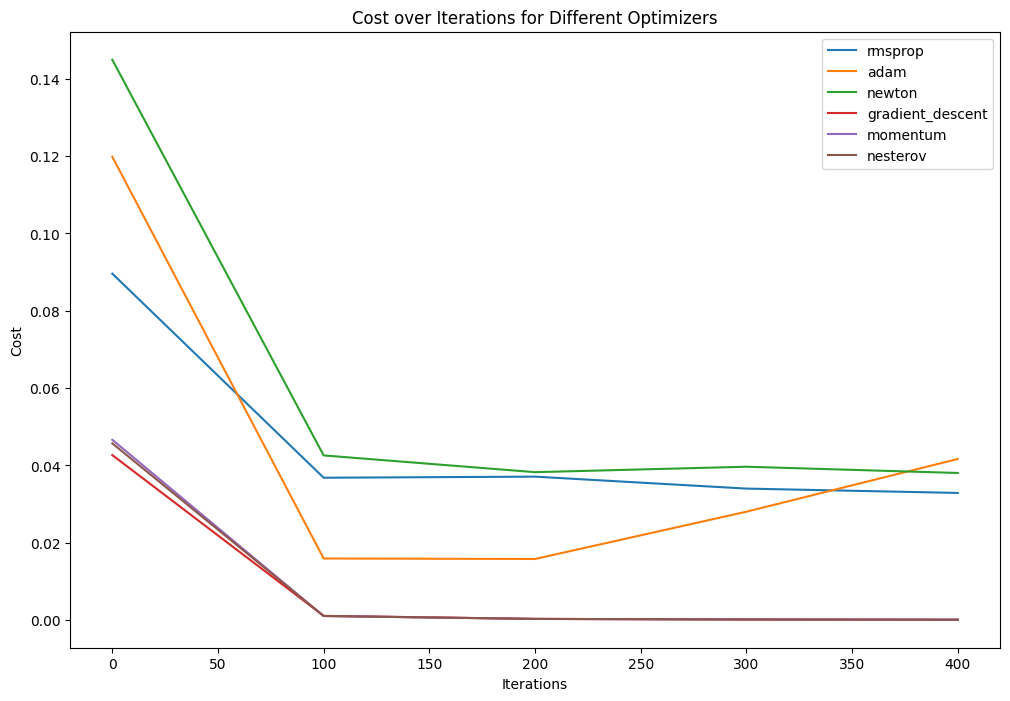

In [12]:
# Plotting the costs for each optimizer
plt.figure(figsize=(12, 8))
for optimizer, costs in costs_dict.items():
    plt.plot(np.arange(len(costs)) * 100, costs, label=optimizer)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.title('Cost over Iterations for Different Optimizers')
plt.show()

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])